In [2]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

from torchvision.datasets import CIFAR10
from torchvision.datasets import FashionMNIST

import clip

import matplotlib.pyplot as plt


In [3]:
BATCH_SIZE = 128

VISUAL_BACKBONES = ['RN50', 'ViT-B/32', 'ViT-B/16']

device = torch.device("cpu")


In [4]:
def prompt_encode(prompt, class_names):
    text = [f"{prompt} {class_name}" for class_name in class_names]
    text_inputs = clip.tokenize(text).to(device)
    return text_inputs

def model_inference(model, image, text_inputs):
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)
    logits_per_image, _ = model(image, text_inputs)
    return logits_per_image

In [5]:
transform_fashion_mnist_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fashion_mnist_test = torchvision.datasets.FashionMNIST(root='/desktop/fashion_mnist', train=False, download=True, transform=transform_fashion_mnist_test)

fashion_mnist_test_dataloader = torch.utils.data.DataLoader(fashion_mnist_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names_fashion_mnist = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = class_names_fashion_mnist
prompt = 'a photo of a'

### dataset intro

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

fashion_mnist = FashionMNIST(root='./data', train=True, transform=transform, download=True)

class_counts = torch.bincount(fashion_mnist.targets)

print(f"选择的新数据集包含 {len(fashion_mnist.classes)} 个类别，样本分布如下：{class_counts}")

选择的新数据集包含 10 个类别，样本分布如下：tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])


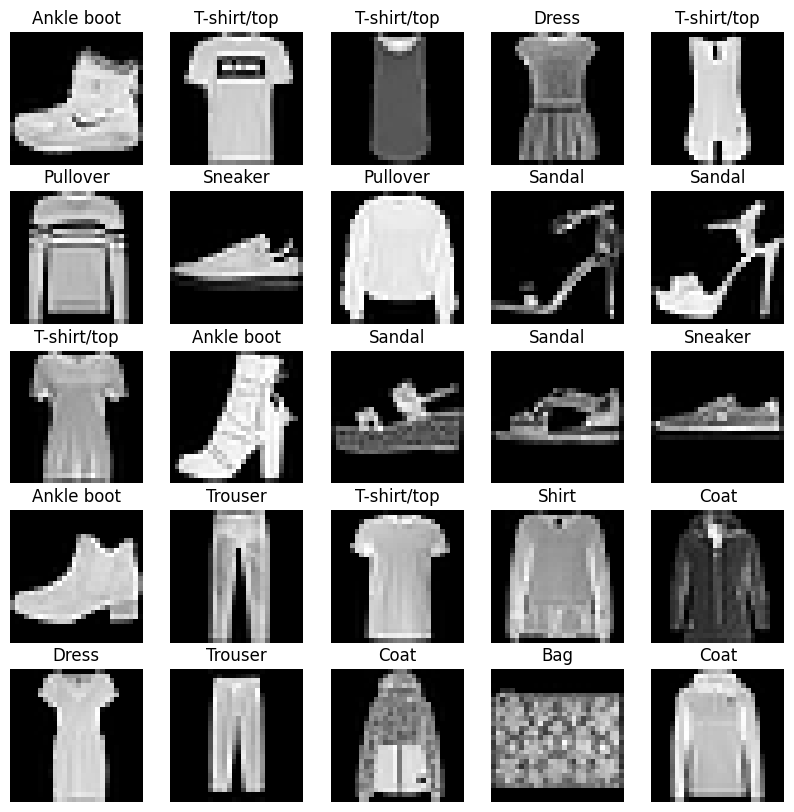

<Figure size 640x480 with 0 Axes>

In [38]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

def show_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # 将三通道图像转换为 NumPy 数组
        plt.imshow(img, cmap='gray')
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()

# 显示图像
show_images(train_dataset, class_names_fashion_mnist)
plt.savefig('fashion_mnist_samples.png')

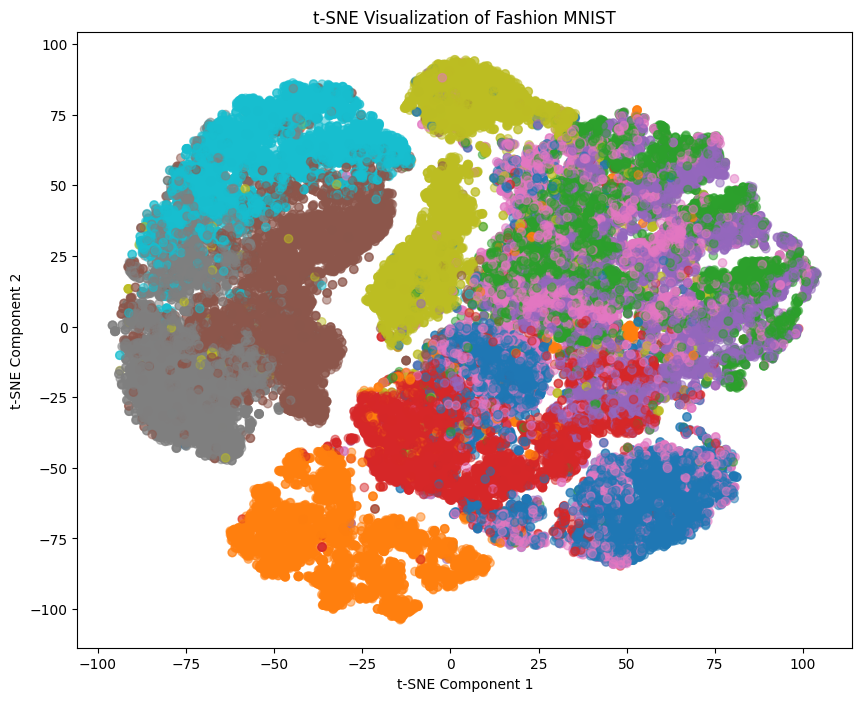

<Figure size 640x480 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 加载 Fashion MNIST 数据集
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

# 获取训练数据和标签
images, labels = next(iter(train_loader))

# 将数据拉平为一维数组
images_flat = images.view(images.size(0), -1)

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(images_flat.detach().numpy())

# 绘制 t-SNE 可视化
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.5)
plt.title('t-SNE Visualization of Fashion MNIST')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.savefig('tsne_visualization.png')

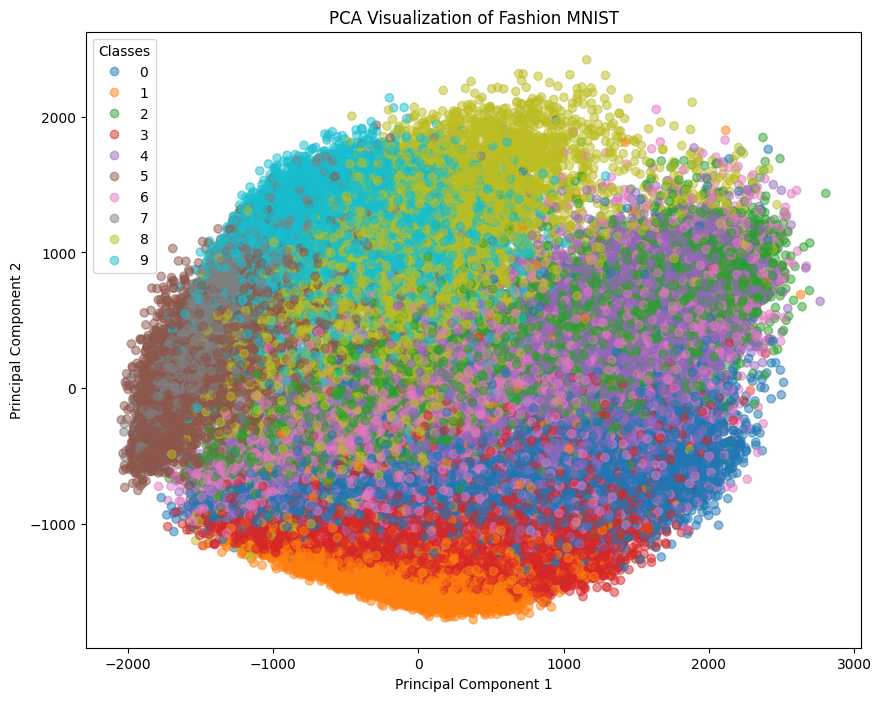

<Figure size 640x480 with 0 Axes>

In [37]:
from sklearn.decomposition import PCA

images = fashion_mnist.data.numpy()
labels = fashion_mnist.targets.numpy()

images_flat = images.reshape(images.shape[0], -1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(images_flat)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.title('PCA Visualization of Fashion MNIST')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()
plt.savefig('PCA Visualization of Fashion MNIST.png')

In [28]:
# 计算并分析基本的统计信息，如均值、标准差等
images_flat = train_dataset.data.numpy().reshape(train_dataset.data.shape[0], -1)
mean_pixel_values = np.mean(images_flat, axis=1)
std_pixel_values = np.std(images_flat, axis=1)

# 分析类别内和类别间的相关性
class_correlations = np.corrcoef(images_flat, rowvar=False)
print(mean_pixel_values)
print(std_pixel_values)
print(class_correlations)

[ 97.25382653 107.90561224  36.55867347 ...  79.77806122  42.74234694
  21.28061224]
[101.7923462  100.83144791  49.69875195 ... 107.51082873  38.50864523
  48.53657186]
[[1.         0.32375319 0.10472538 ... 0.00322514 0.00655955 0.03258322]
 [0.32375319 1.         0.56274698 ... 0.03621486 0.02952959 0.02061494]
 [0.10472538 0.56274698 1.         ... 0.05237515 0.02799011 0.02434284]
 ...
 [0.00322514 0.03621486 0.05237515 ... 1.         0.64793069 0.24132645]
 [0.00655955 0.02952959 0.02799011 ... 0.64793069 1.         0.50140771]
 [0.03258322 0.02061494 0.02434284 ... 0.24132645 0.50140771 1.        ]]


### accuracy for different backbones

Zero-shot performance on Fashion MNIST dataset is 49.35%, visual encoder is RN50.


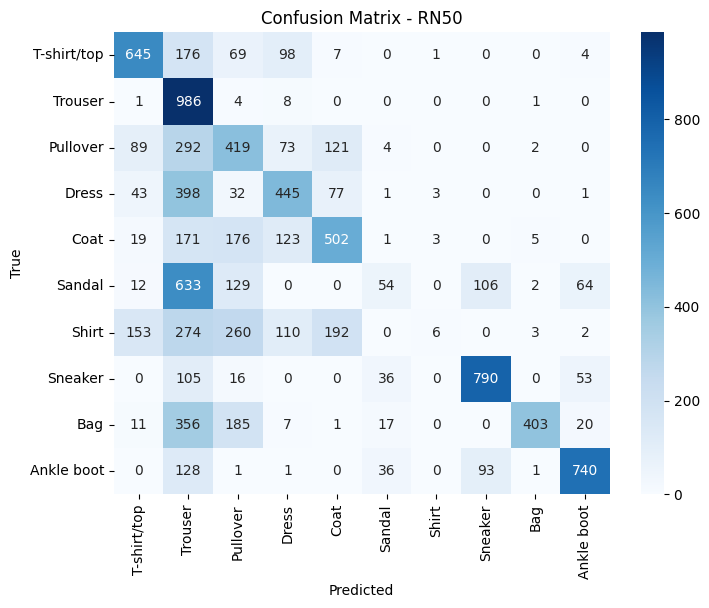

Zero-shot performance on Fashion MNIST dataset is 62.19%, visual encoder is ViT-B/32.


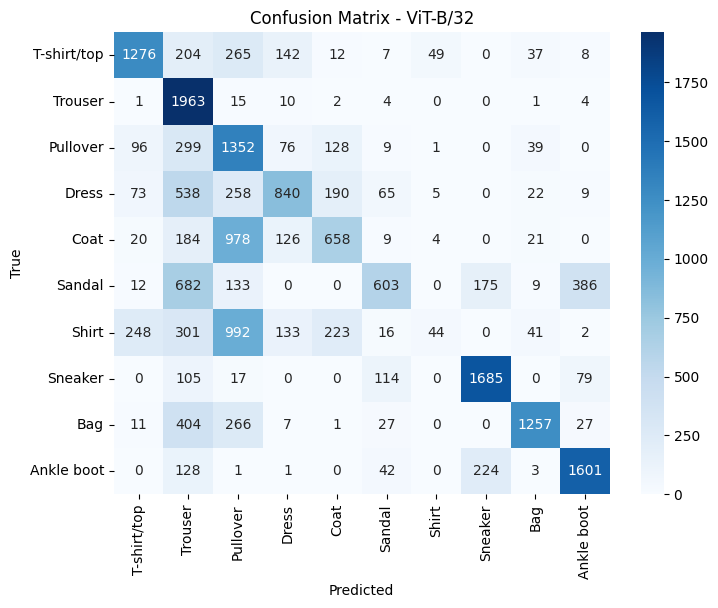

Zero-shot performance on Fashion MNIST dataset is 63.34%, visual encoder is ViT-B/16.


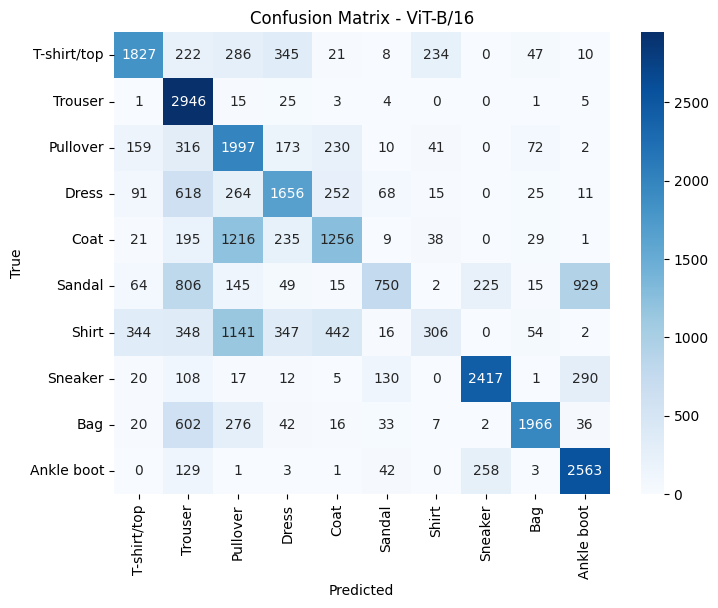

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

accuracy_list = []

all_true_labels = []
all_predicted_labels = []

# Loop through each visual backbone
for VISUAL_BACKBONE in VISUAL_BACKBONES:

    # Load the model
    model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
    model.to(device)

    # Update class_names
    class_names = class_names_fashion_mnist

    testing_loss = []
    testing_acc = []

    with torch.no_grad():
        model.eval()
        for batch_idx, (images, labels) in enumerate(fashion_mnist_test_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Encode the text using the prompt
            text_inputs = prompt_encode(prompt, class_names)

            # Model inference
            logits = model_inference(model, images, text_inputs)

            # Calculate loss (not used in zero-shot)
            loss = F.cross_entropy(logits, labels)
            testing_loss.append(loss.item())

            # Calculate accuracy
            _, predicted = logits.max(1)
            correct = predicted.eq(labels).sum().item()
            acc = correct / BATCH_SIZE
            testing_acc.append(acc)
            
            # Append true and predicted labels to the lists
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

    # Calculate average accuracy for the current backbone
    val_acc = np.mean(testing_acc)
    accuracy_list.append(val_acc)

    print(f"Zero-shot performance on Fashion MNIST dataset is {val_acc * 100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {VISUAL_BACKBONE}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


### baseline model

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 14 * 14)
        x = self.fc1(x)
        return x

# 使用 FashionMNIST 数据集作为示例
transform_fashion_mnist = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = FashionMNIST(root='./data', train=True, transform=transform_fashion_mnist, download=True)
test_dataset = FashionMNIST(root='./data', train=False, transform=transform_fashion_mnist, download=True)

# 使用 DataLoader 加载图像数据
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 训练图像模型
baseline_image_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_image_model.parameters(), lr=0.001)

# 保存每个 epoch 的测试准确度
epoch_accuracies = []

for epoch in range(5):
    baseline_image_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = baseline_image_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    baseline_image_model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = baseline_image_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    epoch_accuracies.append(accuracy)
    print(f'Epoch {epoch + 1}, Test Accuracy: {accuracy:.4f}')

# 保存训练好的模型
#torch.save(baseline_image_model.state_dict(), 'baseline_image_model.pth')

Epoch 1, Test Accuracy: 0.8596
Epoch 2, Test Accuracy: 0.8717
Epoch 3, Test Accuracy: 0.8742
Epoch 4, Test Accuracy: 0.8821
Epoch 5, Test Accuracy: 0.8878


In [14]:
# 计算并输出测试准确度的平均值
average_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)
print(f'Average Test Accuracy: {average_accuracy:.4f}')

Average Test Accuracy: 0.8777


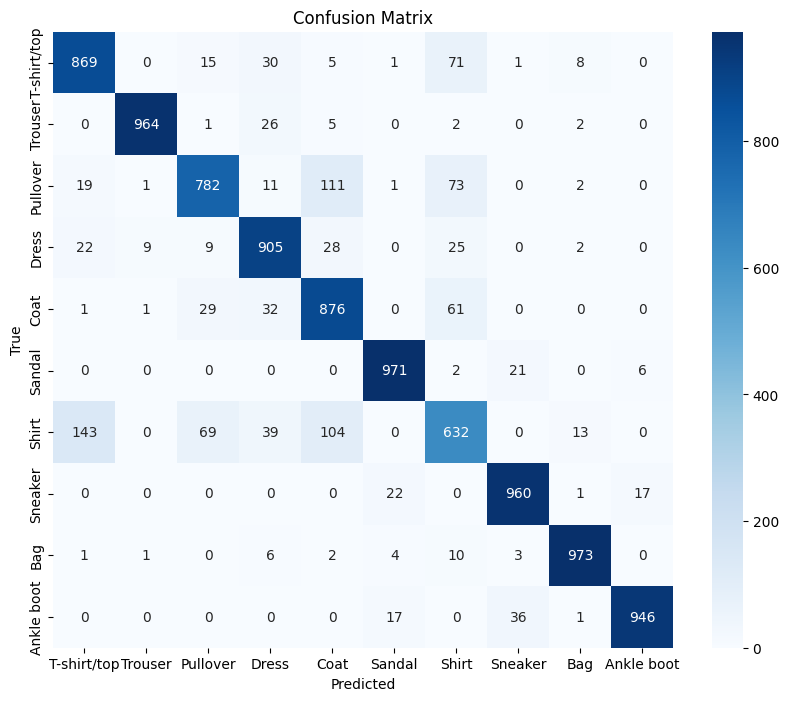

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

baseline_image_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = baseline_image_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 绘制混淆矩阵
class_names_fashion_mnist = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names_fashion_mnist, yticklabels=class_names_fashion_mnist)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Plot

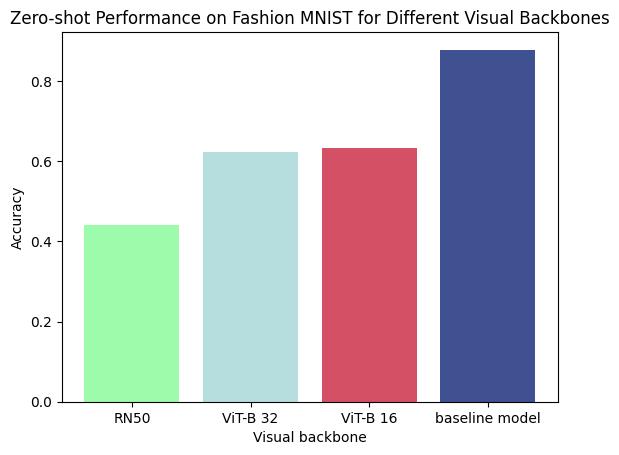

In [16]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['RN50', 'ViT-B 32', 'ViT-B 16', 'baseline model']
values = [0.4395, 0.6219, 0.6334, 0.8777]

colors = np.random.rand(len(categories), 3)

plt.bar(categories, values, color=colors)

plt.title('Zero-shot Performance on Fashion MNIST for Different Visual Backbones')
plt.xlabel('Visual backbone')
plt.ylabel('Accuracy')
plt.show()


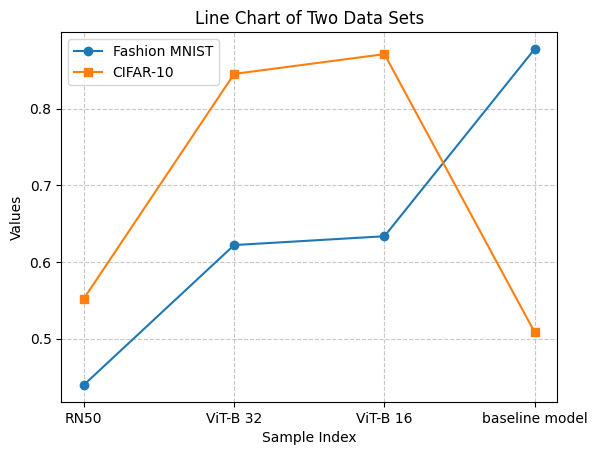

In [18]:
import matplotlib.pyplot as plt

# 两组数据
values1 = [0.4395, 0.6219, 0.6334, 0.8777]
values2 = [0.552, 0.8451, 0.8709,0.5080]

# X 轴的值（假设 X 轴是样本点的索引）
x_values = ['RN50', 'ViT-B 32', 'ViT-B 16', 'baseline model']

# 绘制折线图
plt.plot(x_values, values1, label='Fashion MNIST', marker='o')  # 使用圆点标记
plt.plot(x_values, values2, label='CIFAR-10', marker='s')  # 使用正方形标记

# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)

# 添加标题和标签
plt.title('Line Chart of Two Data Sets')
plt.xlabel('Sample Index')
plt.ylabel('Values')

# 添加图例
plt.legend()

# 显示图形
plt.show()
